In [1]:
import numpy as np
import cv2
from skimage import data
from skimage import color
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.data import protein_transport
from skimage import img_as_float

#test function with a small matrix to test base each reconstsuction method 
def basic_test(func): 
    #shamelessly stolen test data from the Digital image Processing Fourth Edition book as linked in resources
    mask_test = np.array([
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,1,0,0,0,0,0,0,0],
        [0,0,1,1,0,0,0,0,0,0],
        [0,0,0,1,0,0,0,0,0,0],
        [0,0,0,1,1,1,0,0,0,0],
        [0,0,0,1,0,1,0,0,0,0],
        [0,0,0,1,1,1,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0]
    ], dtype=np.uint8)

    marker_test = np.array([
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,1,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0],
    ], dtype=np.uint8)
    mask_test.shape
    marker_test.shape
    result_test = func(marker_test, mask_test)
    fig1, ax1 = plt.subplots(1, 2, figsize=(6, 6), sharey=True)

    ax1[0].imshow(marker_test, cmap=plt.cm.gray)
    ax1[1].imshow(result_test, cmap=plt.cm.gray)




structuring element for constant reconstruct is:
 [[1 1 1]
 [1 1 1]
 [1 1 1]]


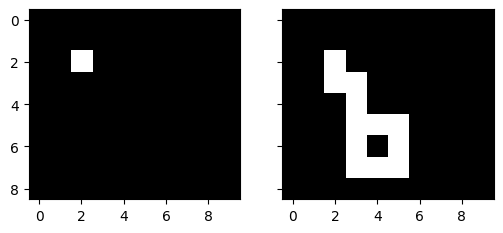

In [2]:
#basic reconstruction using a preset structuring element with a size of radius * 2 + 1
def morphological_reconstruct(marker: np.ndarray, mask: np.ndarray, radius: int = 1):
   #Do geodesic dilation of the markers white keeping them limited by the mask during each iteration.
   
    #constant kernel predefined for all pixels
    kernel = np.ones(shape=(radius * 2 + 1,) * 2, dtype=np.uint8)
    print("structuring element for constant reconstruct is:\n", kernel)
    while True:
        expanded = cv2.dilate(src=marker, kernel=kernel)
        cv2.bitwise_and(src1=expanded, src2=mask, dst=expanded)

        if (marker == expanded).all():
            return expanded
        marker = expanded
        
basic_test(morphological_reconstruct)        

In [3]:
def get_protein_image():
    image_sequence = protein_transport()
    # Load the image
    image = image_sequence[0, 0, :, :]
    return image

def get_coins(): 
    return data.coins()

In [4]:
def generate_binary_mask(image):
    mask = np.zeros(image.shape, dtype=np.uint8)
    count_X=0
    for x, mask_x in zip(image, mask):
        count_X+=1
        count_Y=0
        for y, mask_y in zip(x, mask_x):
            count_Y+=1
            if(count_Y >= mask.shape[1] or count_X >= mask.shape[0]): 
                break;
            #take from it only pixels that are whiter than black values from 0 to 255 are here
            if(y > 20 ): 
                mask[count_X][count_Y] = 1
    return mask


In [5]:
def generate_float_mask(image):
    #this one does not work very well with the normal reconstruction and shows poorer results with the adaptive one
    mask = np.copy(image)
    mask[1:-1, 1:-1] = image.max()
    return mask

In [6]:
def generate_mask(image): 
    mask = np.copy(image)
    count_X=0
    for x, mask_x in zip(image, mask):
        count_X+=1
        count_Y=0
        for y, mask_y in zip(x, mask_x):
            count_Y+=1
            if(count_Y >= mask.shape[1] or count_X >= mask.shape[0]): 
                break;
            #take from it only pixels that are whiter than black values from 0 to 255 are here
            #here i tried adding additional conditions to make the mask know about less elements from the original image,
            #always the adaptive approach reaches better result 
            if(y > 20): 
                mask[count_X][count_Y] = y
    return mask

In [7]:
def get_radius(x, y, threshold):
    #to do: get a better criteria of this maybe
    if y <= threshold: 
        return 10
    return 5

In [8]:
#a custom implementation of geodesic dilation, since the radius of the structuring element we want to pass
#is different depending of the color value compared to a heuristic of adjacency i chose- otsu's threshold of each pixel(weather its a foreground or background pixel)
def geodesic_dilation_adaptive(image, mask):
 
    dilated_image = np.copy(image)
    threshold = threshold_otsu(image)
    rows, cols = image.shape
    
    queue = []
    
    for i in range(rows):
        for j in range(cols):
            if mask[i, j] != 0:
                queue.append((i, j))
    
    while len(queue) > 0:
        # Get the next pixel from the queue
        x, y = queue.pop(0)
        
        # Get the structuring element for the current pixel
        r = get_radius(x, y, threshold)
        
        # Check the 8-neighbors of the pixel
        for i in range(-r, r+1):
            for j in range(-r, r+1):
                # Check if the neighbor is inside the image
                if 0 <= x+i < rows and 0 <= y+j < cols:
                    # Check if the neighbor is not already dilated
                    if dilated_image[x+i, y+j] == 0:
                        # Dilate the neighbor
                        dilated_image[x+i, y+j] = 1
                        # Add the neighbor to the queue
                        queue.append((x+i, y+j))
    return dilated_image

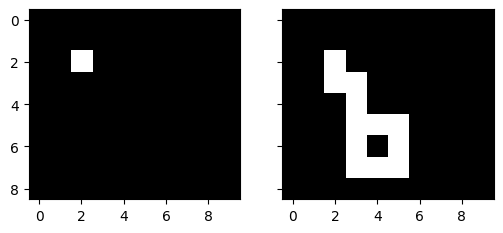

In [9]:
#here is the main loop of the adaptive reconstruction, it works similiarly to the basic one but instead of using cv2.dilate,
#we use the custom geodesic_dilation_adaptive method that uses a different sized structuring element on each pixel
def adaptive_morphological_reconstruct(marker: np.ndarray, mask: np.ndarray):
    while True:
        expanded = geodesic_dilation_adaptive(marker, mask)
        cv2.bitwise_and(src1=expanded, src2=mask, dst=expanded)

        if (marker == expanded).all():
            return expanded
        marker = expanded

basic_test(adaptive_morphological_reconstruct)

In [10]:
def compare_adaptive_vs_non_adaptive_binarized(image): 
    mask = generate_binary_mask(image)
    reconst_image_nonadaptive = morphological_reconstruct(image, mask)
    reconst_image_adaptive = adaptive_morphological_reconstruct(image, mask)
    fig1, ax1 = plt.subplots(1, 3, figsize=(12, 12), sharey=True)
    
    ax1[0].set_title('Reference image')
    ax1[1].set_title('Morphological reconstruction')
    ax1[2].set_title('Adaptive morphological reconstruction')
    ax1[0].imshow(image, cmap=plt.cm.viridis)
    ax1[1].imshow(reconst_image_nonadaptive, cmap=plt.cm.viridis)
    ax1[2].imshow(reconst_image_adaptive, cmap=plt.cm.viridis)

def compare_adaptive_vs_non_adaptive_gray_scale(image): 
    image = img_as_float(image)
    mask = generate_mask(image)
   # mask_non_adaptive = generate_mask(image)
    reconst_image_nonadaptive = morphological_reconstruct(image, mask)
    reconst_image_adaptive = adaptive_morphological_reconstruct(image, mask)
    fig1, ax1 = plt.subplots(1, 3, figsize=(12, 12), sharey=True)
    ax1[0].set_title('Reference image')
    ax1[1].set_title('Morphological reconstruction')
    ax1[2].set_title('Adaptive morphological reconstruction')
    ax1[0].imshow(image, cmap=plt.cm.viridis)
    ax1[1].imshow(reconst_image_nonadaptive, cmap=plt.cm.viridis)
    ax1[2].imshow(reconst_image_adaptive, cmap=plt.cm.viridis)   

structuring element for constant reconstruct is:
 [[1 1 1]
 [1 1 1]
 [1 1 1]]


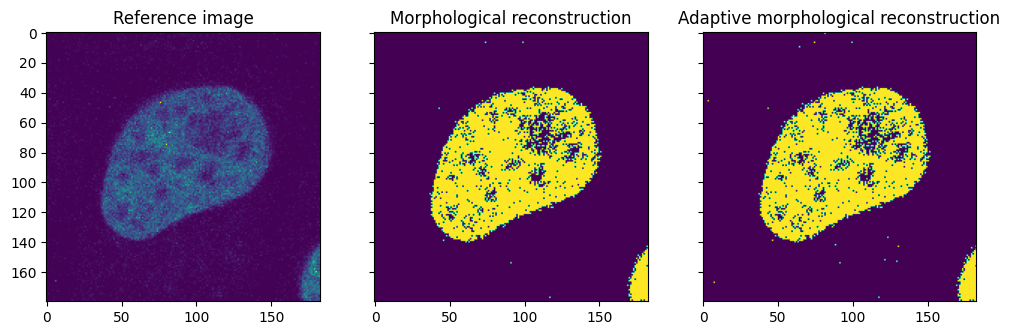

In [11]:
image = get_protein_image()
compare_adaptive_vs_non_adaptive_binarized(image)

structuring element for constant reconstruct is:
 [[1 1 1]
 [1 1 1]
 [1 1 1]]


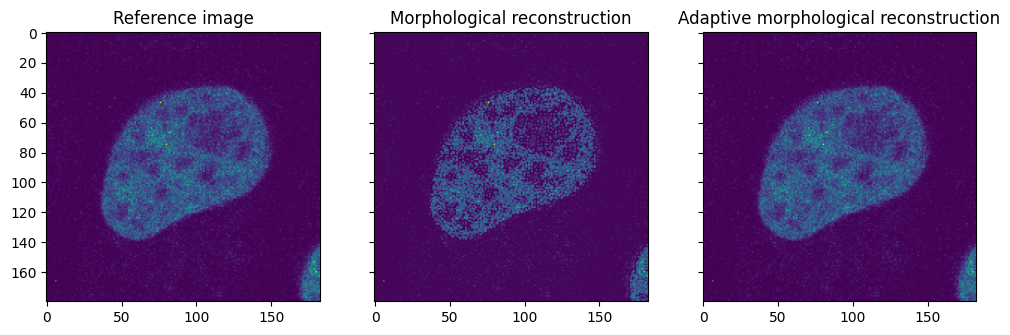

In [12]:
compare_adaptive_vs_non_adaptive_gray_scale(image)

structuring element for constant reconstruct is:
 [[1 1 1]
 [1 1 1]
 [1 1 1]]


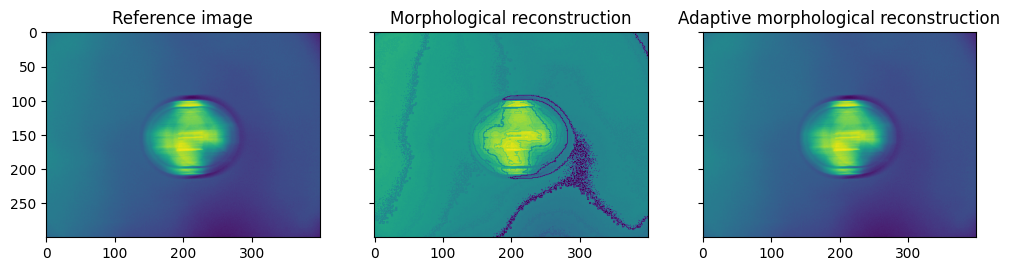

In [13]:
clock = data.clock()
#compare_adaptive_vs_non_adaptive_binarized(clock)
compare_adaptive_vs_non_adaptive_gray_scale(clock)

structuring element for constant reconstruct is:
 [[1 1 1]
 [1 1 1]
 [1 1 1]]


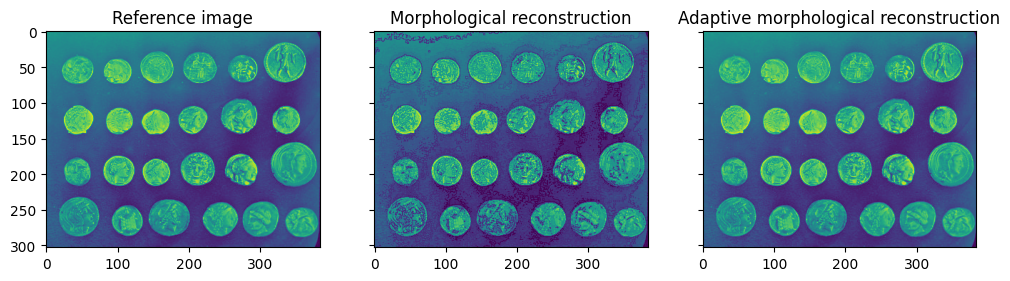

In [14]:
coins = data.coins()
compare_adaptive_vs_non_adaptive_gray_scale(coins)

structuring element for constant reconstruct is:
 [[1 1 1]
 [1 1 1]
 [1 1 1]]


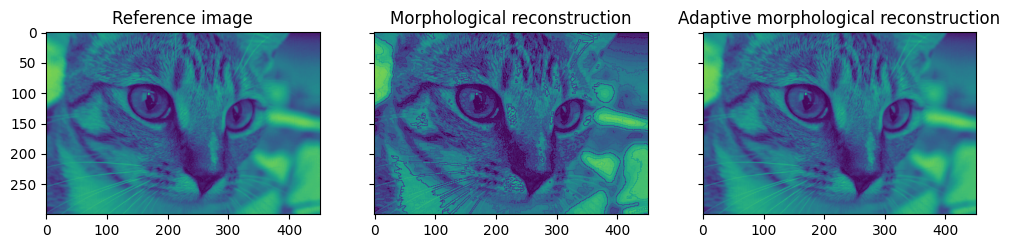

In [15]:
catto = data.chelsea()[:,:,2]
compare_adaptive_vs_non_adaptive_gray_scale(catto)